In [1]:
#!venv\Scripts\activate.ps1
#!pip install -r requirements.txt

In [2]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

uci_data = pd.read_csv("train.csv")
unicamp_data = pd.read_csv("Dataset_5971.csv")
pd.set_option('display.max_colwidth',None)


After importing the necessary libraries, the next step is to clean the data, in this case, two different data sets are being used, `train.csv` is the data set from [UCI machine learning repository](https://archive.ics.uci.edu/dataset/228/sms+spam+collection) and `Dataset_5971.csv` was taken from this research paper: [SMS PHISHING DATASET FOR MACHINE LEARNING AND PATTERN RECOGNITION](https://data.mendeley.com/datasets/f45bkkt8pr/1)

the next step is to clean the data sets, and label them correctly


In [3]:
from sklearn.preprocessing import OrdinalEncoder

unicamp_data.rename(columns={'TEXT':'sms'},inplace=True)
columns_change = ['label','URL','EMAIL','PHONE']
uniData = unicamp_data.copy()
ord_enc = OrdinalEncoder()
uniData[columns_change] = ord_enc.fit_transform(unicamp_data[columns_change])



In [4]:
unicamp_data.iloc[117]

label                                                                                                                                                                    Spam
sms      \tEnjoy the jamster videosound gold club with your credits for 2 new videosounds+2 logos+musicnews! get more fun from jamster.co.uk! 16+only Help? call: 09701213186
URL                                                                                                                                                                        No
EMAIL                                                                                                                                                                      No
PHONE                                                                                                                                                                     yes
Name: 117, dtype: object

After testing for a while I noticed that my second data set had more than one style of writing 'spam' and also contained 'Spam' and the same thing for smishing.

In the case of smishing I will merge it to be the same as spam, since both terms related to the same thing and porpuse of the research.

In [5]:
unicamp_data.loc[unicamp_data.label == 'Spam','label'] = 'spam'
unicamp_data.loc[unicamp_data.label == 'smishing','label'] = 'spam'
unicamp_data.loc[unicamp_data.label == 'Smishing','label'] = 'spam'

unicamp_data.loc[unicamp_data.label == 'Smishing']

,label,sms,URL,EMAIL,PHONE


After erasing the spelling problems it is viable to apply the Ordinal Encoder to our data set, another step to simplify and test more, will be ereasing the url, email and phone for the moment, It is contemplated to take in count in the next steps

In [6]:
unicamp_data.drop(columns=['URL','EMAIL','PHONE'],axis=1,inplace=True)
columns_change = ['label']
unicamp_data

,label,sms
0,ham,Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..
1,ham,What's up? Do you want me to come online? If you are free we can talk sometime�
2,ham,So u workin overtime nigpun?
3,ham,"Also sir, i sent you an email about how to log into the usc payment portal. I.ll send you another message that should explain how things are back home. Have a great weekend."
4,spam,Please Stay At Home. To encourage the notion of staying at home. All tax-paying citizens are entitled to �305.96 or more emergency refund. smsg.io/fCVbD
...,...,...
5966,ham,:( but your not here....
5967,ham,Becoz its &lt;#&gt; jan whn al the post ofice is in holiday so she cn go fr the post ofice...got it duffer
5968,ham,Its a valentine game. . . send dis msg to all ur friends. . If 5 answers r d same then someone really loves u. . Ques- which colour suits me the best?
5969,ham,We r outside already.


After deleting necessary columns we can fit the encoder, which is a fast way to set ham and spam as number values

In [7]:
uniData = unicamp_data.copy()
uniData[columns_change] = ord_enc.fit_transform(unicamp_data[columns_change])

In [8]:
uniData.describe

<bound method NDFrame.describe of       label  \
0       0.0   
1       0.0   
2       0.0   
3       0.0   
4       1.0   
...     ...   
5966    0.0   
5967    0.0   
5968    0.0   
5969    0.0   
5970    0.0   

                                                                                                                                                                                sms  
0                                          Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..  
1                                                                                                   What's up? Do you want me to come online? If you are free we can talk sometime�  
2                                                                                                                                                      So u workin overtime nigpun?  
3     Also sir, i sent you an email about how to log into

In [9]:
from sklearn.model_selection import train_test_split
X = uniData.sms
y = uniData.label

#train split
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)
print([X_train.shape, X_valid.shape])

[(4776,), (1195,)]


# Text preprosessing
first, the text will be tokenized as is, after that, there will be experiments without stop words and applying stemmig technics
## 1- TOKENIZER

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

#to implement padding fo r the lenght of sequences, advance technic called ragged tensor
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [11]:
vocab_size = 10000
embedding_dim = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 4800

#Data is needed to be in list to work with the tokenizeer
X_train = list(X_train)
X_valid = list(X_valid)

#fit and declare the tokenizer
tok = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tok.fit_on_texts(X_train)

t_word_index = tok.word_index #get the word index (dictionary)

#this is only for training data
t_sequences = tok.texts_to_sequences(X_train) #create the sentence sequence inside the list
t_padded = pad_sequences(t_sequences, padding = padding_type) #deal with large sentences

#print(test_sentences)
print(t_word_index)
print(t_sequences)
print(t_padded.shape)


{'<OOV>': 1, 'to': 2, 'i': 3, 'you': 4, 'a': 5, 'the': 6, 'u': 7, 'and': 8, 'is': 9, 'in': 10, 'your': 11, 'me': 12, 'for': 13, 'call': 14, 'my': 15, 'of': 16, 'have': 17, 'on': 18, 'it': 19, '2': 20, 'now': 21, 'that': 22, 'are': 23, 'or': 24, 'so': 25, 'not': 26, 'at': 27, 'but': 28, 'with': 29, 'will': 30, 'be': 31, 'can': 32, 'get': 33, "i'm": 34, 'if': 35, 'we': 36, 'no': 37, 'this': 38, 'ur': 39, 'do': 40, 'just': 41, '4': 42, 'free': 43, 'up': 44, 'from': 45, 'out': 46, 'go': 47, 'ok': 48, 'when': 49, 'how': 50, 'all': 51, 'know': 52, 'what': 53, 'then': 54, 'good': 55, 'gt': 56, 'lt': 57, 'only': 58, 'got': 59, 'come': 60, 'like': 61, 'am': 62, 'was': 63, 'time': 64, 'day': 65, 'its': 66, 'please': 67, 'there': 68, 'text': 69, 'he': 70, 'love': 71, 'want': 72, 'as': 73, 'our': 74, 'by': 75, 'send': 76, 'going': 77, 'been': 78, 'dear': 79, 'mobile': 80, 'stop': 81, 'ü': 82, 'one': 83, 'has': 84, 'txt': 85, 'today': 86, 'reply': 87, 'about': 88, 'r': 89, 'home': 90, 'claim': 91, 

In [12]:
#get the word index
v_sequences = tok.texts_to_sequences(X_valid) #create the sentence sequence inside the list
v_padded = pad_sequences(v_sequences, padding = padding_type) #deal with large sentences

In [13]:
print(v_padded.shape)
print(t_padded.shape)

(1195, 121)
(4776, 189)


## 2- EMBEDING

In [14]:
import numpy as np
#convert data types to make it work with tensor flow
t_padded = np.array(t_padded)
y_train = np.array(y_train)

v_padded = np.array(v_padded)
X_valid = np.array(X_valid)

In [15]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

## 2. MODEL TRANING

In [16]:
model_1.summary()
#emb = model_1.layers[0].get_weights()[0]
#print(emb[t_word_index['i']])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
num_epochs = 40
history = model_1.fit(t_padded, y_train, epochs=num_epochs, validation_data=(v_padded,y_valid), verbose=2)

Epoch 1/40
150/150 - 1s - 8ms/step - accuracy: 0.8088 - loss: 0.4906 - val_accuracy: 0.8042 - val_loss: 0.4732
Epoch 2/40
150/150 - 0s - 1ms/step - accuracy: 0.8130 - loss: 0.4668 - val_accuracy: 0.8042 - val_loss: 0.4676
Epoch 3/40
150/150 - 0s - 2ms/step - accuracy: 0.8130 - loss: 0.4643 - val_accuracy: 0.8042 - val_loss: 0.4626
Epoch 4/40
150/150 - 0s - 1ms/step - accuracy: 0.8130 - loss: 0.4598 - val_accuracy: 0.8042 - val_loss: 0.4515
Epoch 5/40
150/150 - 0s - 1ms/step - accuracy: 0.8130 - loss: 0.4504 - val_accuracy: 0.8042 - val_loss: 0.4316
Epoch 6/40
150/150 - 0s - 1ms/step - accuracy: 0.8130 - loss: 0.4334 - val_accuracy: 0.8042 - val_loss: 0.3988
Epoch 7/40
150/150 - 0s - 1ms/step - accuracy: 0.8132 - loss: 0.3908 - val_accuracy: 0.8795 - val_loss: 0.2986
Epoch 8/40
150/150 - 0s - 1ms/step - accuracy: 0.8689 - loss: 0.2792 - val_accuracy: 0.9665 - val_loss: 0.1792
Epoch 9/40
150/150 - 0s - 1ms/step - accuracy: 0.9445 - loss: 0.1768 - val_accuracy: 0.9590 - val_loss: 0.1133
E

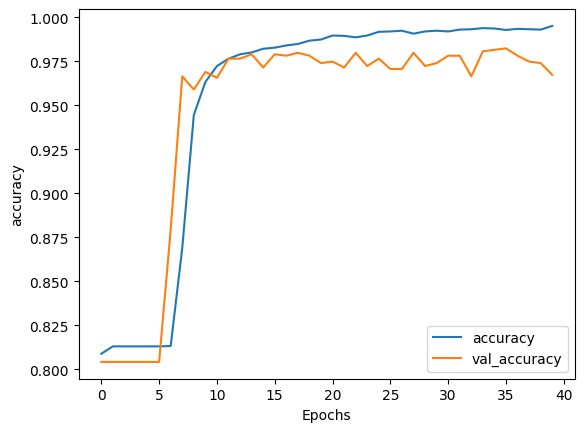

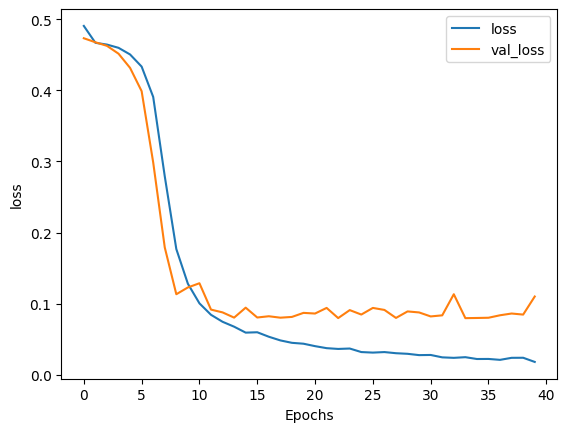

In [18]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## 3-FUN GRAPHING

e:\UREDataScience - Copy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 146 (\x92) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\UREDataScience - Copy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 148 (\x94) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\UREDataScience - Copy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37413 (\N{CJK UNIFIED IDEOGRAPH-9225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\UREDataScience - Copy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12328 (\N{HANGZHOU NUMERAL EIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\UREDataScience - Copy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 150 (\x96) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\UREDataScience 

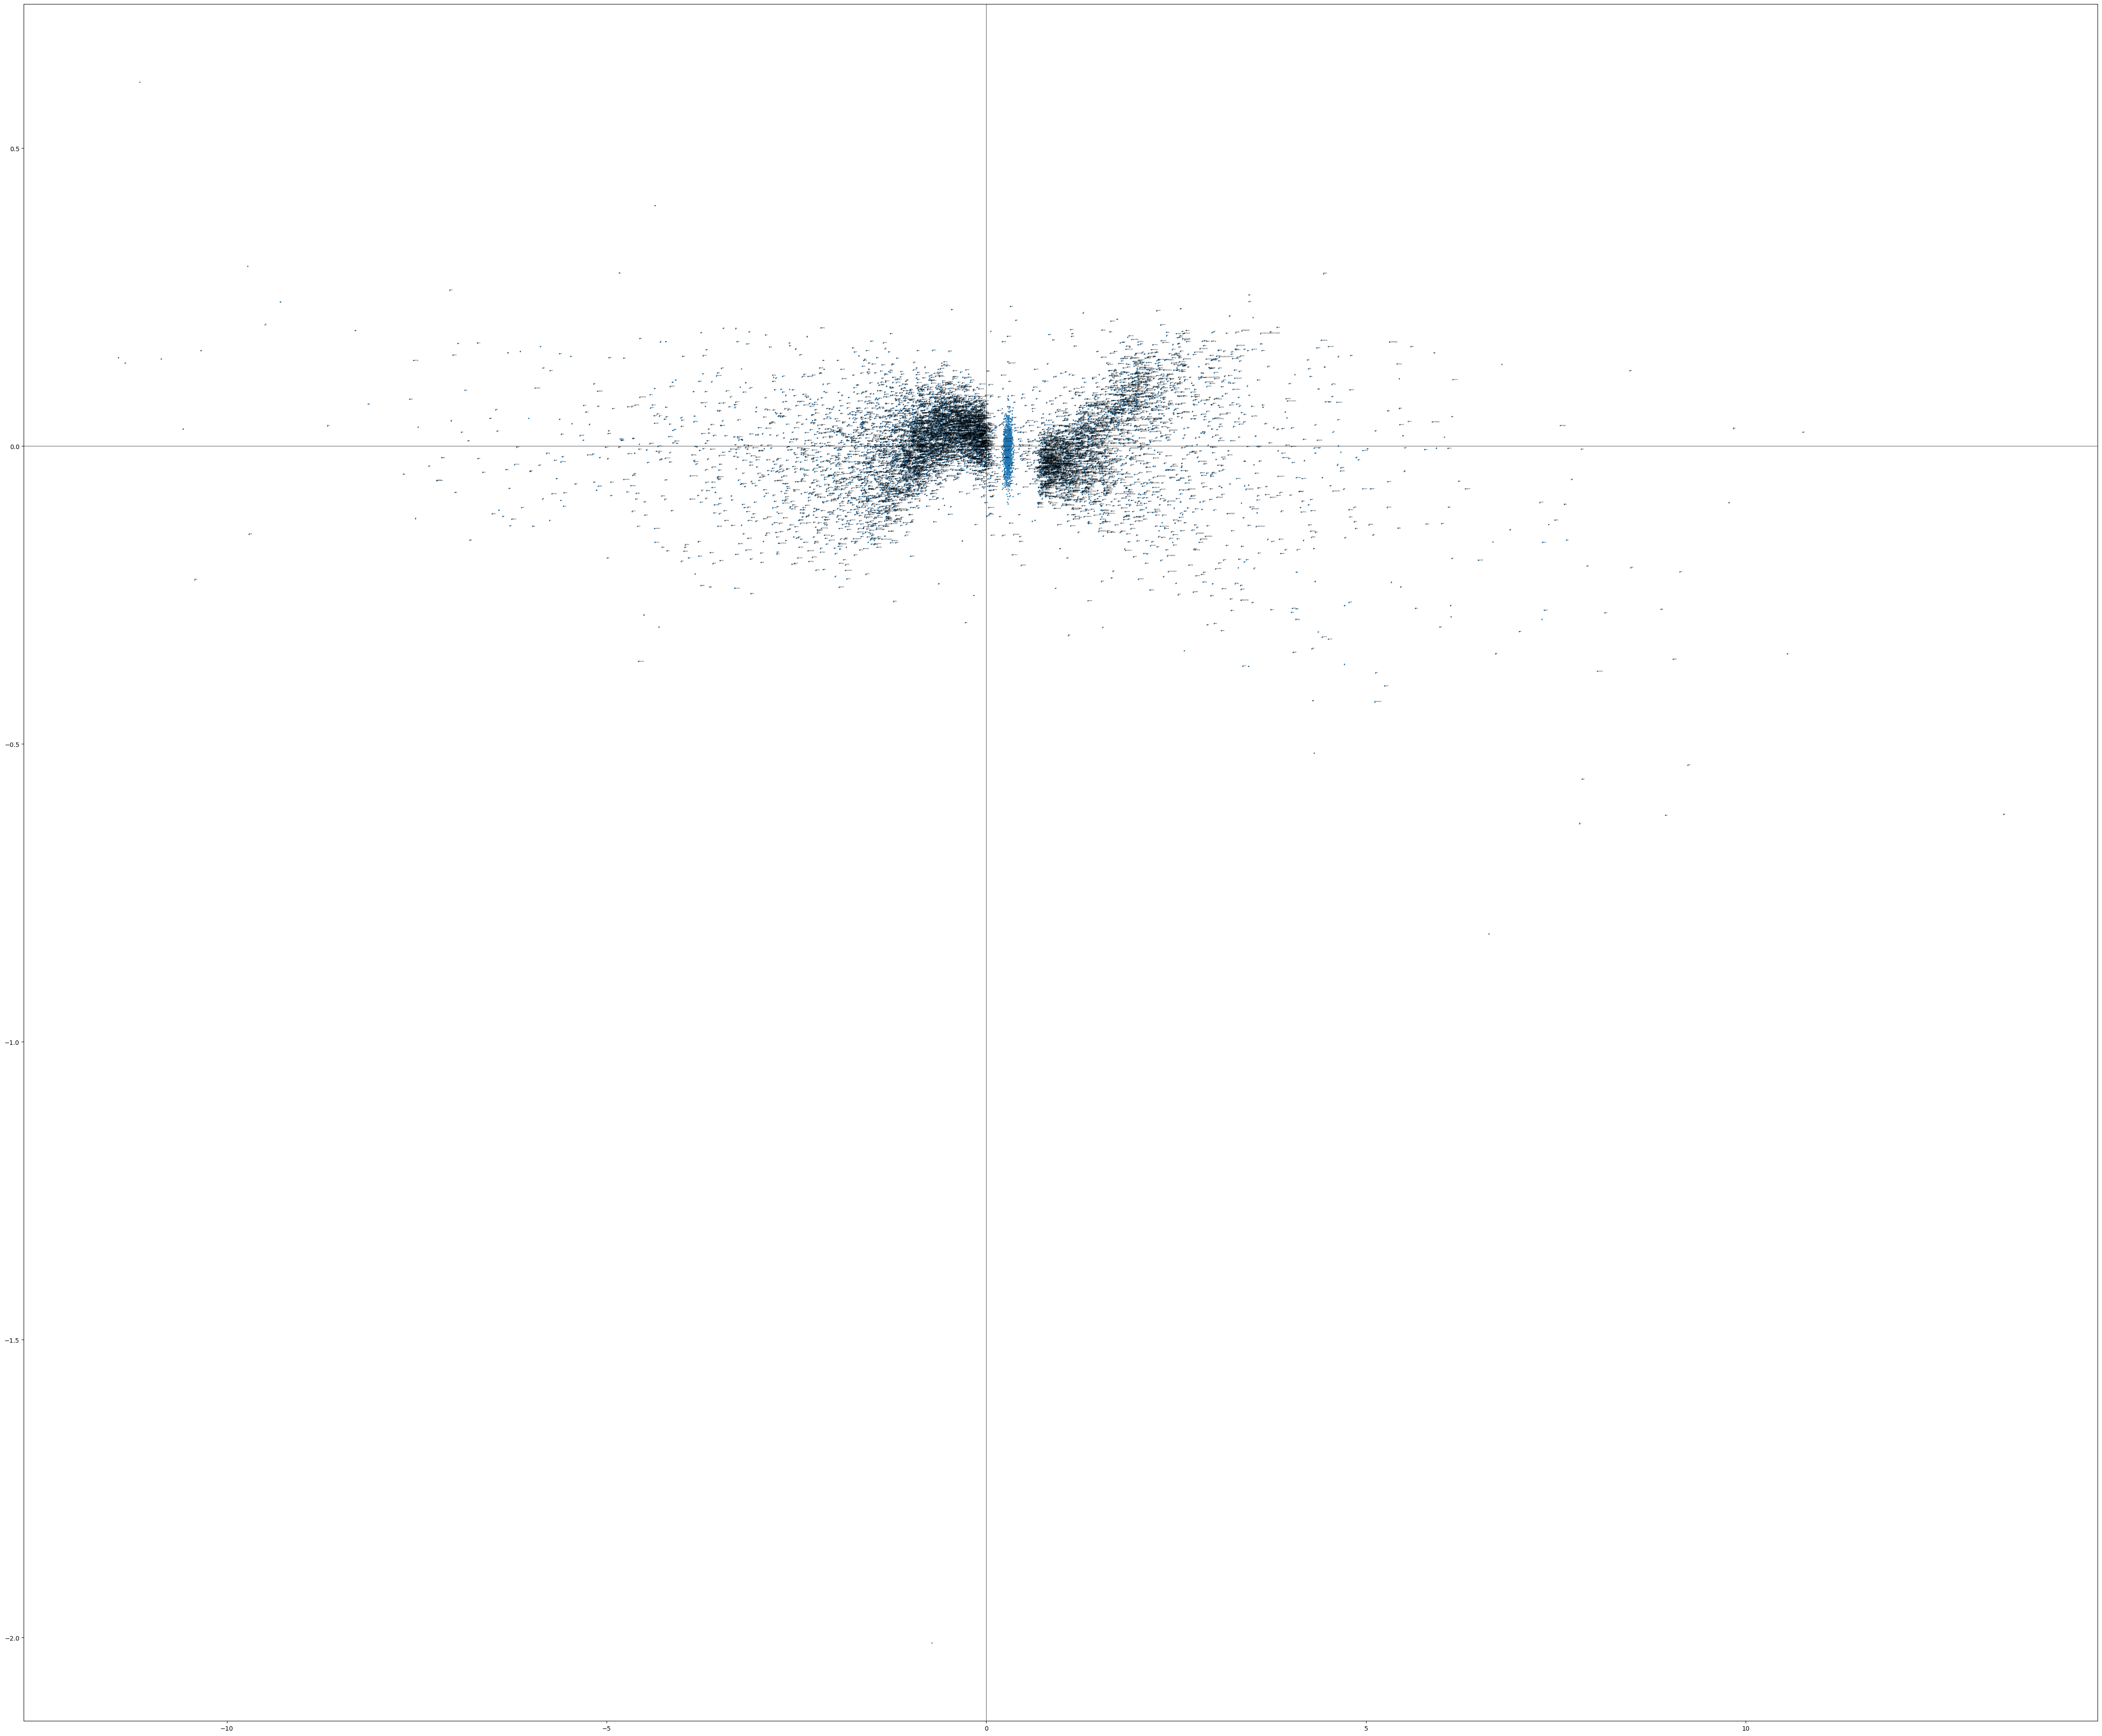

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_embeddings(embeddings, word_index):
    # Reduce dimensionality
    pca = PCA(n_components=2)
    embeddings_pca = pca.fit_transform(embeddings)

    # Plot
    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1],s=1)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    # Annotate the points
    for word, idx in word_index.items():
        plt.annotate(word, (embeddings_pca[idx, 0], embeddings_pca[idx, 1]),fontsize=2)
    plt.show()

# Usage
embeddings = model_1.layers[0].get_weights()[0]
plot_embeddings(embeddings, tok.word_index)


e:\UREDataScience - Copy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 146 (\x92) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\UREDataScience - Copy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 148 (\x94) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\UREDataScience - Copy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37413 (\N{CJK UNIFIED IDEOGRAPH-9225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\UREDataScience - Copy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12328 (\N{HANGZHOU NUMERAL EIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\UREDataScience - Copy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 150 (\x96) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\UREDataScience 

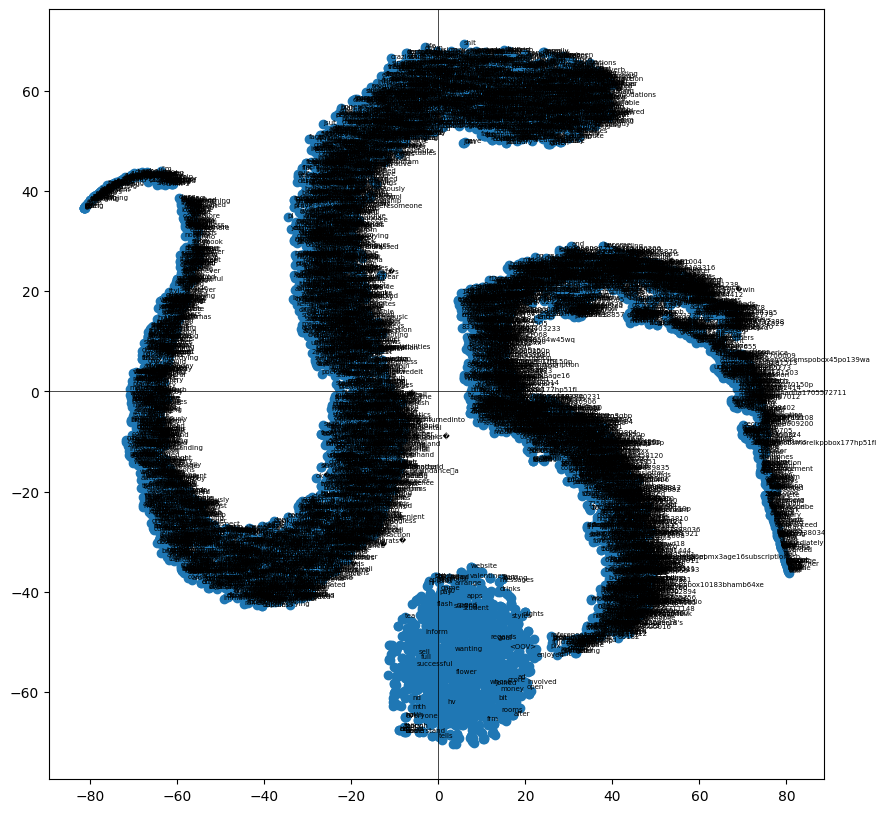

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_embeddings_tsne(embeddings, word_index):
    # Reduce dimensionality
    tsne = TSNE(n_components=2)
    embeddings_tsne = tsne.fit_transform(embeddings)

    # Plot
    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])

    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    # Annotate the points
    for word, idx in word_index.items():
        plt.annotate(word, (embeddings_tsne[idx, 0], embeddings_tsne[idx, 1]),fontsize=5)
    plt.show()

# Usage
embeddings = model_1.layers[0].get_weights()[0]
plot_embeddings_tsne(embeddings, tok.word_index)


e:\UREDataScience - Copy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 146 (\x92) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\UREDataScience - Copy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 148 (\x94) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\UREDataScience - Copy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37413 (\N{CJK UNIFIED IDEOGRAPH-9225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\UREDataScience - Copy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12328 (\N{HANGZHOU NUMERAL EIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\UREDataScience - Copy\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 150 (\x96) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\UREDataScience 

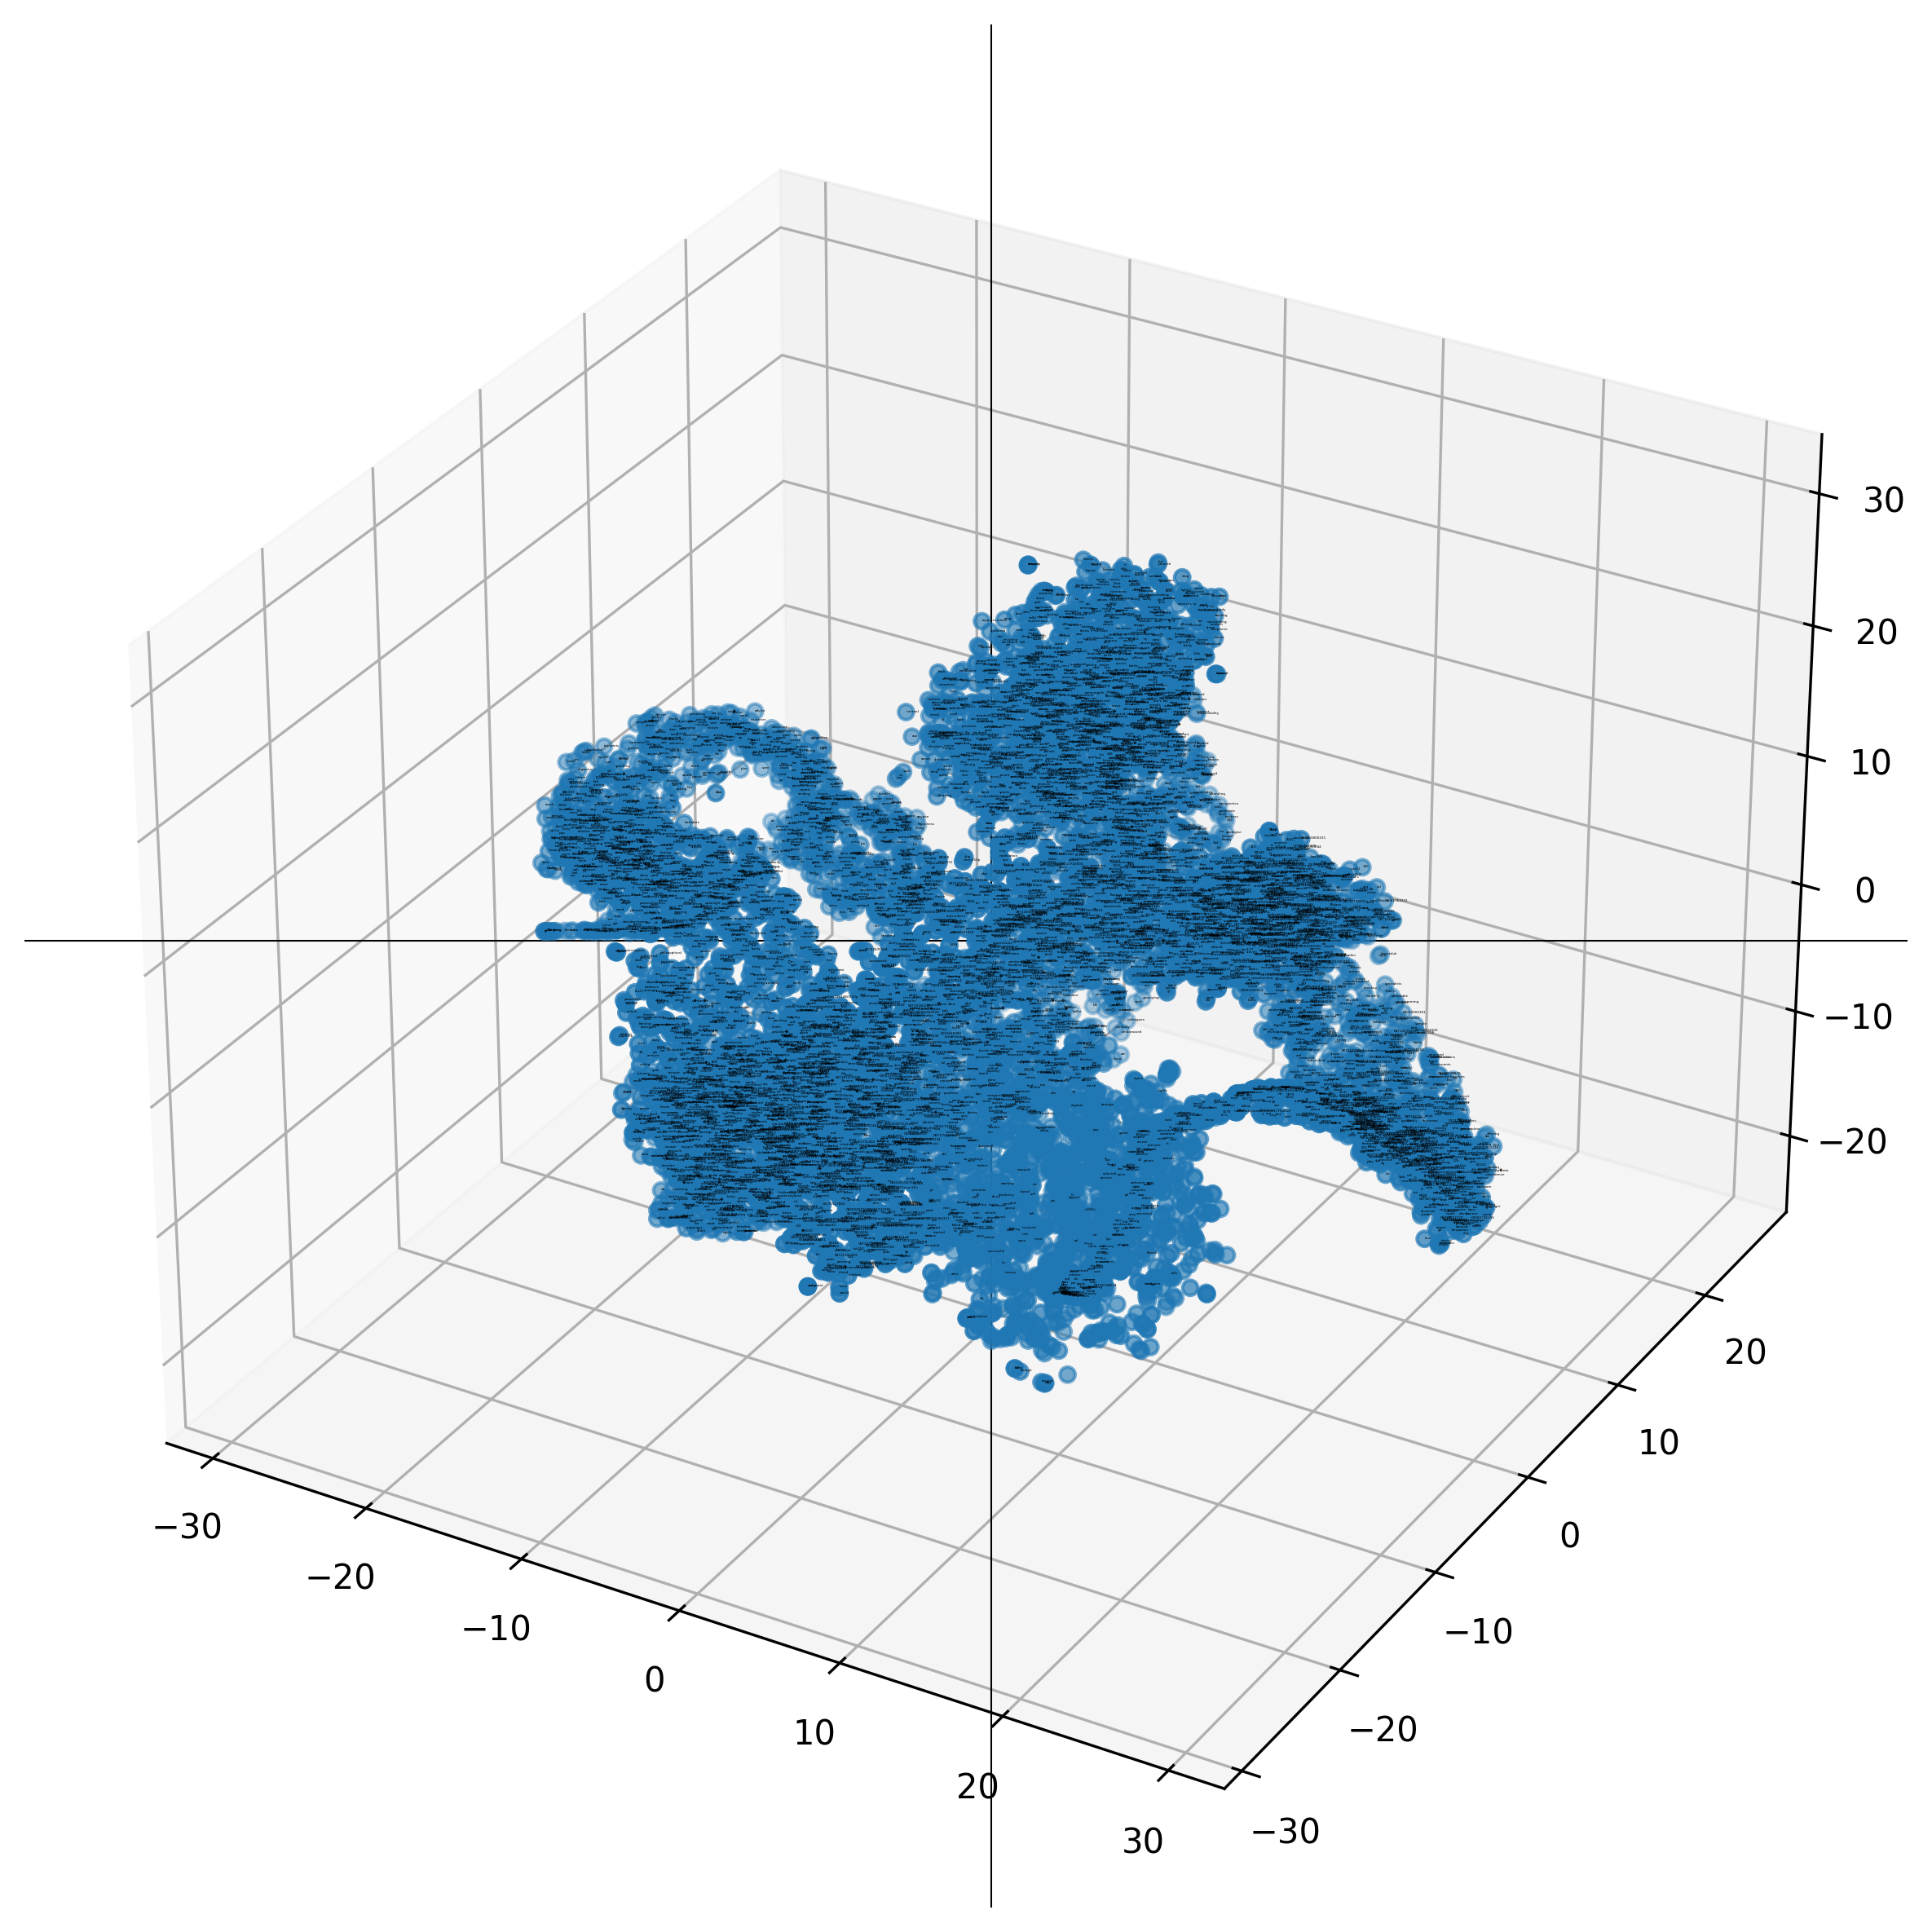

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_embeddings_tsne_3d(embeddings, word_index):
    # Reduce dimensionality
    tsne = TSNE(n_components=3)
    embeddings_tsne = tsne.fit_transform(embeddings)

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 10),dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], embeddings_tsne[:, 2], s=20)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    # Annotate the points
    for word, idx in word_index.items():
        ax.text(embeddings_tsne[idx, 0], embeddings_tsne[idx, 1], embeddings_tsne[idx, 2], word, fontsize=1)

    plt.show()

# Usage
embeddings = model_1.layers[0].get_weights()[0]
plot_embeddings_tsne_3d(embeddings, tok.word_index)


## 4 - testing accuracy

In [22]:
pred_test = uci_data.sms[1:2]
pred_test = tok.texts_to_sequences(pred_test)
padd = pad_sequences(pred_test,padding=padding_type)
prediction = model_1.predict(padd)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[[1.6544753e-28]]


In [23]:
uci_data[1:2]

,sms,label
1,Ok lar... Joking wif u oni...\n,0
